In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


from xgboost import XGBRegressor
# import gensim
import string
import tensorflow as tf
import keras

from tensorflow import keras


from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, InputSpec
from tensorflow.python.keras.layers.recurrent import LSTM
# from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()

from keras import __version__
tf.keras.__version__ = __version__
# from rl.agents import DQNAgent
# from rl.policy import BoltzmannQPolicy
# from rl.memory import SequentialMemory

<h3>We will test two models in this Notebook</h3>

1) [LSTM](#LSTM)
2) [GRU](#GRU)

## Load preprocessed files

In [2]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### Text Featurization Class

In [4]:
import numpy as np
import pandas as pd
from keras_preprocessing.sequence import pad_sequences

class TextFeaturization:
    
    def __init__(self, pad_length=30): # pad_length was originally 350
        self.word_mapping = None
        self.total_words = None
        self.pad_length = pad_length
        
    def build_vocabulary(self, sentences):
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        vocab_dict = dict.fromkeys(vocab, 0)
        for x in sentences:
            for word in x.split():
                vocab_dict[word] += 1
        return vocab_dict
    
    def get_mapping(self, vocab_dict):
        kv = np.array(list(vocab_dict.items()))
        df = pd.DataFrame(kv, columns=["Word", "Count"])
        df['Count'] = df['Count'].astype('int')
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        df['mapping'] = range(1, len(df) + 1)
        df.drop(columns=['Count'], inplace=True)
        return dict(zip(df['Word'], df['mapping']))
    
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    def transform(self, sentences):
        if self.word_mapping is None:
            raise ValueError("Fit method must be called before transform.")
        
        whole = []
        for x in sentences:
            part = [self.word_mapping[word] for word in x.split() if word in self.word_mapping]
            whole.append(part)
        
        padded_sequences = pad_sequences(whole, maxlen=self.pad_length)
        return padded_sequences



### Fit the model with the preprocessed text 

In [5]:
text_feat = TextFeaturization()
text_feat.fit(X_train['preprocessed_text'])

### Transform

In [6]:
lstm_train = text_feat.transform(X_train['preprocessed_text'])
lstm_test = text_feat.transform(X_test['preprocessed_text'])
lstm_cv = text_feat.transform(X_cv['preprocessed_text'])

In [7]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(600000, 30)
(200000, 30)
(80000, 30)


In [8]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

## LSTM Model

### Create the LSTM model

In [9]:
from tensorflow.python.keras.layers.recurrent import LSTM

# Create the model
# embedding_vecor_length = 100
embedding_vecor_length = 30
total_words = text_feat.total_words
print(total_words)

model_LSTM = Sequential()
model_LSTM.add(Embedding(total_words+1, embedding_vecor_length, input_length=30)) # input_length was originally 350
model_LSTM.add(LSTM(64, return_sequences=True))  # Standard LSTM layer
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model_LSTM.summary())

130028
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 30)            3900870   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            24320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 3,958,279
Trainable params: 3,958,279
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list

In [12]:
history = model_LSTM.fit(lstm_train, y_train, epochs=5, batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5
293/293 [==============================] - 48s 163ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0182 - val_mse: 0.0182

Epoch 00001: val_loss did not improve from 0.01891
Epoch 2/5
293/293 [==============================] - 48s 163ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0176 - val_mse: 0.0176

Epoch 00002: val_loss did not improve from 0.01891
Epoch 3/5
293/293 [==============================] - 48s 165ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0175 - val_mse: 0.0175

Epoch 00003: val_loss did not improve from 0.01891
Epoch 4/5
293/293 [==============================] - 92s 314ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0176 - val_mse: 0.0176

Epoch 00004: val_loss did not improve from 0.01891
Epoch 5/5
293/293 [==============================] - 48s 164ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0177 - val_mse: 0.0177

Epoch 00005: val_loss did not improve from 0.01891


In [13]:
# Save LSTM model
# model_LSTM.save('lstm_model.h5')
# tf.keras.models.save_model(model_LSTM, 'lstm_model.h5')

### Loss Curves

Text(0.5, 1.0, 'Loss Curves')

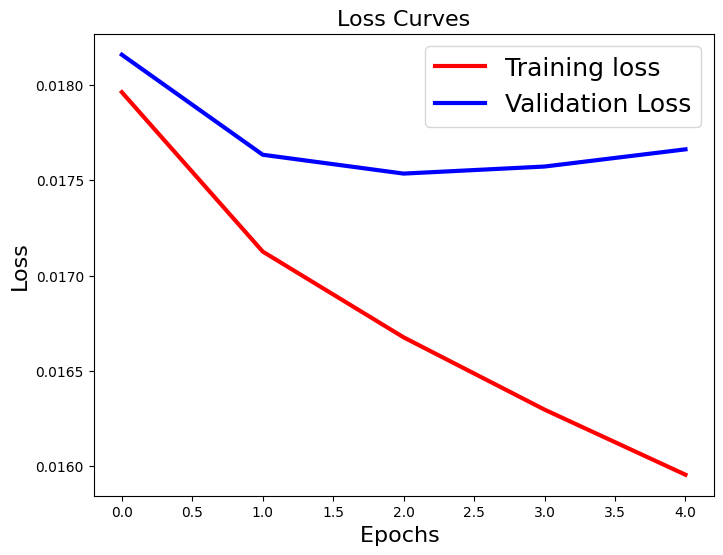

In [13]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Test the model

In [28]:
# Preprocess the new sentence
new_sentence = "Don't talk like that"
preprocessed_sentence = text_feat.transform([new_sentence])
prediction = model_LSTM.predict(preprocessed_sentence)

toxicity_threshold = 0.5
# toxicity_threshold = optimal_threshold
is_toxic = prediction[0][0] >= toxicity_threshold

print(prediction[0][0])
if is_toxic:
    print(f"'{new_sentence}' is toxic.")
else:
    print(f"'{new_sentence}' is not toxic.")


0.021458346
'Don't talk like that' is not toxic.


<h1 id="GRU">GRU</h1>

### Create the GRU model

In [29]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import GRU

# Define the model
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=total_words+1, output_dim=embedding_vecor_length, input_length=30))
model_GRU.add(GRU(128, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(64))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1, activation='sigmoid'))

# Compile the model
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_GRU.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 30)            3900870   
_________________________________________________________________
gru (GRU)                    (None, 30, 128)           61056     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,999,047
Trainable params: 3,999,047
Non-trainable params: 0
____________________________________________

In [30]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list

In [32]:
# Train the model
history = model_GRU.fit(
    lstm_train, 
    y_train,
    epochs=5,
    batch_size=2048,
    # batch_size=32,
    validation_data=(lstm_cv, y_cv), 
    verbose = 1, 
    callbacks=callbacks_list
)

Epoch 1/5
293/293 [==============================] - 74s 252ms/step - loss: 0.2500 - accuracy: 0.6989 - val_loss: 0.2476 - val_accuracy: 0.7007

Epoch 00001: val_loss did not improve from 0.25241
Epoch 2/5
293/293 [==============================] - 74s 251ms/step - loss: 0.2437 - accuracy: 0.6992 - val_loss: 0.2472 - val_accuracy: 0.7006

Epoch 00002: val_loss did not improve from 0.25241
Epoch 3/5
293/293 [==============================] - 76s 258ms/step - loss: 0.2407 - accuracy: 0.6993 - val_loss: 0.2490 - val_accuracy: 0.7007

Epoch 00003: val_loss did not improve from 0.25241
Epoch 4/5
293/293 [==============================] - 89s 303ms/step - loss: 0.2377 - accuracy: 0.6995 - val_loss: 0.2496 - val_accuracy: 0.7000

Epoch 00004: val_loss did not improve from 0.25241
Epoch 5/5
293/293 [==============================] - 88s 302ms/step - loss: 0.2346 - accuracy: 0.6998 - val_loss: 0.2509 - val_accuracy: 0.7002

Epoch 00005: val_loss did not improve from 0.25241


### Loss Curves

Text(0.5, 1.0, 'Loss Curves')

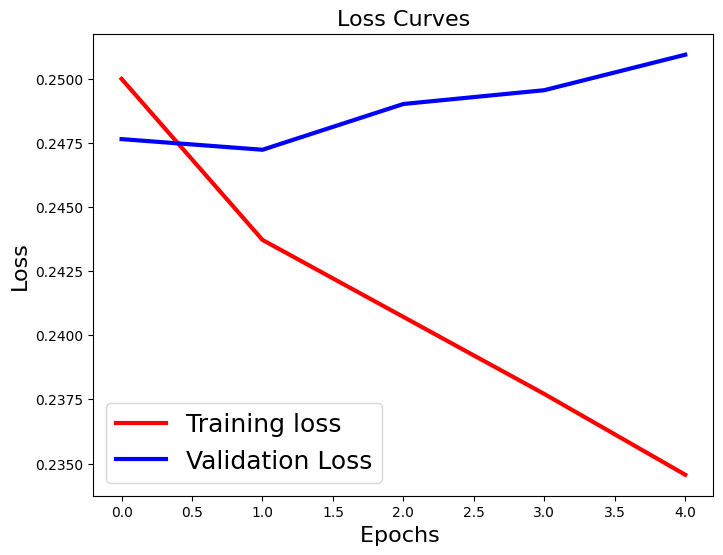

In [33]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Test the model

In [2]:
# Preprocess the new sentence
new_sentence = "Don't talk like that"
preprocessed_sentence = text_feat.transform([new_sentence])

# Perform prediction
prediction = model_GRU.predict(preprocessed_sentence)

# Interpret the prediction (assuming binary classification)
toxicity_threshold = 0.05
is_toxic = prediction[0][0] >= toxicity_threshold
print(prediction[0][0])

if is_toxic:
    print("The sentence is toxic.")
else:
    print("The sentence is not toxic.")


NameError: name 'text_feat' is not defined

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test_df = pd.read_csv('./data/test.csv', index_col='id', engine='python')
y_test = test_df['target'] 

# Predict on test set
lstm_predictions = model_LSTM.predict(lstm_test)
gru_predictions = model_GRU.predict(lstm_test)

# Binarize the predictions
lstm_pred_binary = (lstm_predictions >= 0.5).astype(int)
gru_pred_binary = (gru_predictions >= 0.5).astype(int)

# Calculate metrics for LSTM
lstm_accuracy = accuracy_score(y_test, lstm_pred_binary)
lstm_precision = precision_score(y_test, lstm_pred_binary)
lstm_recall = recall_score(y_test, lstm_pred_binary)
lstm_f1 = f1_score(y_test, lstm_pred_binary)
lstm_roc_auc = roc_auc_score(y_test, lstm_predictions)

# Calculate metrics for GRU
gru_accuracy = accuracy_score(y_test, gru_pred_binary)
gru_precision = precision_score(y_test, gru_pred_binary)
gru_recall = recall_score(y_test, gru_pred_binary)
gru_f1 = f1_score(y_test, gru_pred_binary)
gru_roc_auc = roc_auc_score(y_test, gru_predictions)

# Print the results
print("LSTM Model Performance:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")
print(f"F1 Score: {lstm_f1:.4f}")
print(f"ROC AUC: {lstm_roc_auc:.4f}")

print("\nGRU Model Performance:")
print(f"Accuracy: {gru_accuracy:.4f}")
print(f"Precision: {gru_precision:.4f}")
print(f"Recall: {gru_recall:.4f}")
print(f"F1 Score: {gru_f1:.4f}")
print(f"ROC AUC: {gru_roc_auc:.4f}")

# Plotting the comparison
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
lstm_scores = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_roc_auc]
gru_scores = [gru_accuracy, gru_precision, gru_recall, gru_f1, gru_roc_auc]

x = np.arange(len(metrics))

plt.figure(figsize=(12, 8))
plt.bar(x - 0.2, lstm_scores, 0.4, label='LSTM')
plt.bar(x + 0.2, gru_scores, 0.4, label='GRU')
plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Comparison of LSTM and GRU Models')
plt.legend()
plt.show()


NameError: name 'pd' is not defined